In [89]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from wordcloud import WordCloud
from IPython.display import display, HTML

In [109]:
database_file = '../data/made-project.sqlite'

# Define the time period (e.g., January 2021)
start_date = '2021-01-01'
end_date = '2021-12-31'

conn = sqlite3.connect(database_file)

stock_query = f"SELECT DISTINCT \"index\" as stock FROM stock_exchange_data WHERE date BETWEEN '{start_date}' AND '{end_date}';"
stock_names = pd.read_sql_query(stock_query, conn)

conn.close()

display(HTML(stock_names.head().to_html()))


In [110]:
conn = sqlite3.connect(database_file)

while True:
    stock_name = input('Select a stock index for analysis (or type "exit" to quit): ')
    
    if stock_name.lower() == 'exit':
        break  # Exit the loop if the user enters 'exit'
    
    # Query stock data
    stock_query = f"SELECT strftime('%Y-%m-%d', date) as date, \"index\" as stock, open, high, low, close, adj_close, volume FROM stock_exchange_data WHERE date BETWEEN '{start_date}' AND '{end_date}' AND \"index\" = '{stock_name}';"
    stock_data = pd.read_sql_query(stock_query, conn)

    # Query news data
    news_query = f"SELECT strftime('%Y-%m-%d', date) as date, title, description, sentiment_compound, keywords, source FROM analysed_news WHERE date BETWEEN '{start_date}' AND '{end_date}';"
    news_data = pd.read_sql_query(news_query, conn)

    # Check if records are found for the given stock index
    if not stock_data.empty:
        # Display or process the data as needed
        print(f"Data found for stock index {stock_name}:\n")
        
        print("Stock Data:")
        display(HTML(stock_data.head().to_html()))

        print("\nNews Data:")
        display(HTML(news_data.head().to_html()))
       
        break  
    else:
        print(f"No data found for stock index {stock_name}. Please try again.\n")

conn.close()

Select a stock index for analysis (or type "exit" to quit):  NYA


Data found for stock index NYA:

Stock Data:



News Data:


Various financial metrics and technical indicators derived from the standard OHLC (Open, High, Low, Close) data columns to provide additional insights into a stock's performance. Here are some commonly calculated columns:

1. **Daily Returns:**
   - This column represents the percentage change in the stock's closing price from one day to the next.
   - Formula: 
     - Daily Return = (Closeₜ - Closeₜ₋₁) / Closeₜ₋₁

2. **Log Returns:**
   - Logarithmic returns are often used in financial analysis and can be more appropriate for certain calculations.
   - Formula: 
     - Log Return = ln(Closeₜ / Closeₜ₋₁)

3. **Moving Averages:**
   - Moving averages smooth out price data to identify trends over a specified period.
   - Common types include the Simple Moving Average (SMA) and Exponential Moving Average (EMA).

4. **Volatility:**
   - Volatility measures the degree of variation of a trading price series over time.
   - It can be calculated using the standard deviation of daily returns or log returns.

5. **Relative Strength Index (RSI):**
   - RSI is a momentum oscillator that measures the speed and change of price movements.
   - It ranges from 0 to 100 and is used to identify overbought or oversold conditions.

6. **Moving Average Convergence Divergence (MACD):**
   - MACD is a trend-following momentum indicator that shows the relationship between two moving averages.
   - It consists of the MACD line, sigcating overbought or oversold conditions.


In [111]:
# Calculating new data columns for Stock analysis 

# Daily Returns
stock_data['daily_return'] = stock_data['close'].pct_change().fillna(0)

# Log Returns
stock_data['log_return'] = (
    (stock_data['close'] / stock_data['close'].shift(1))
    .apply(lambda x: 0 if pd.isna(x) else np.log(x))
)

# Moving Averages
window = 10  # You can adjust the window size as needed
stock_data['sma'] = stock_data['close'].rolling(window=window).mean()
stock_data['ema'] = stock_data['close'].ewm(span=window, adjust=False).mean()

# Volatility
stock_data['volatility'] = stock_data['log_return'].rolling(window=window).std()

# Relative Strength Index (RSI)
rsi_window = 14  # You can adjust the window size as needed
delta = stock_data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_window).mean()
avg_loss = loss.rolling(window=rsi_window).mean()
rs = avg_gain / avg_loss
stock_data['rsi'] = 100 - (100 / (1 + rs))

# Moving Average Convergence Divergence (MACD)
short_window = 12
long_window = 26
signal_window = 9
stock_data['short_ma'] = stock_data['close'].ewm(span=short_window, adjust=False).mean()
stock_data['long_ma'] = stock_data['close'].ewm(span=long_window, adjust=False).mean()
stock_data['macd'] = stock_data['short_ma'] - stock_data['long_ma']
stock_data['signal_line'] = stock_data['macd'].ewm(span=signal_window, adjust=False).mean()
stock_data['macd_histogram'] = stock_data['macd'] - stock_data['signal_line']

# Display the updated DataFrame
display(HTML(stock_data.head().to_html()))

for col in stock_data.columns:
    print(col)

print("\n")
for col in news_data.columns:
    print(col)

merged_data = pd.merge(stock_data, news_data, on='date', how='inner')

date
stock
open
high
low
close
adj_close
volume
daily_return
log_return
sma
ema
volatility
rsi
short_ma
long_ma
macd
signal_line
macd_histogram


date
title
description
sentiment_compound
keywords
source


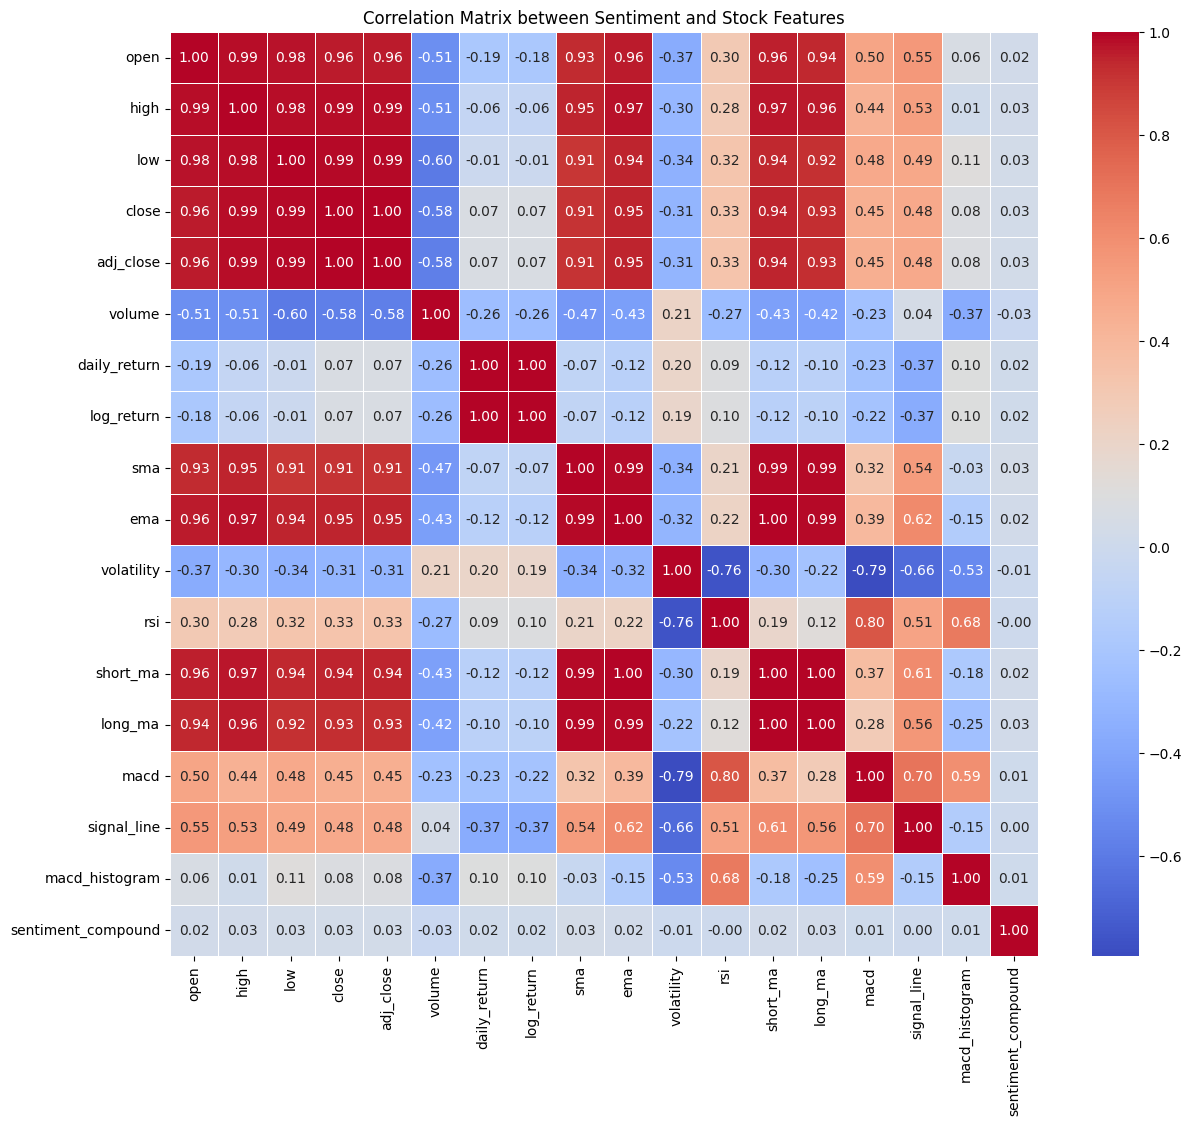

In [112]:
# Compute correlation matrix
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = merged_data[numeric_columns].corr()

# Perform further analysis or visualization as needed
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between Sentiment and Stock Features')
plt.show()


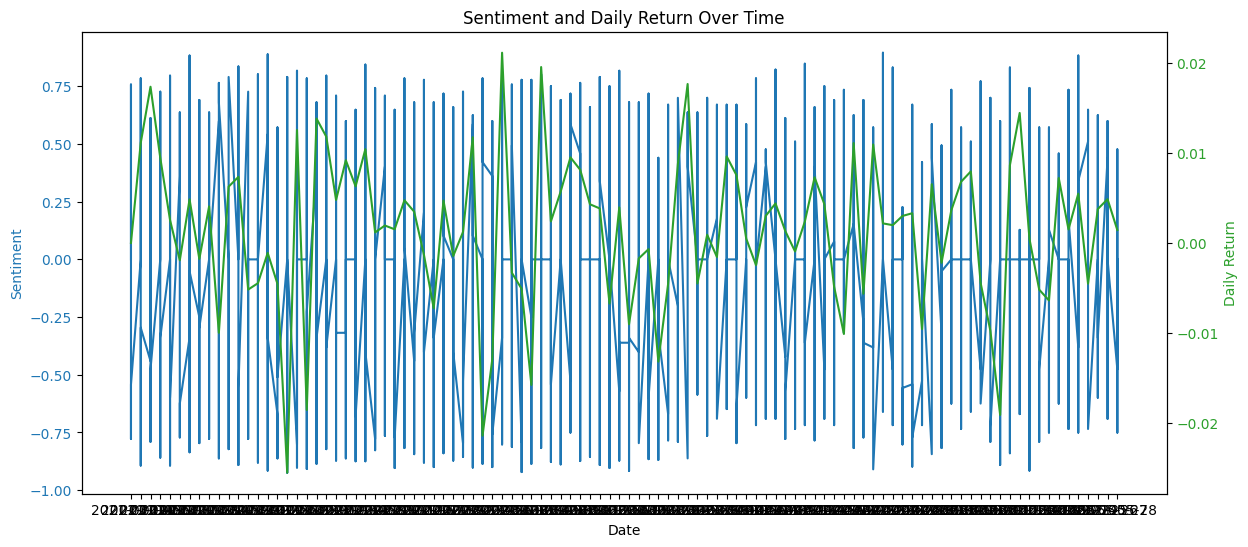

In [113]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plotting Sentiment on the first y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment', color=color)
ax1.plot(merged_data['date'], merged_data['sentiment_compound'], label='Sentiment', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a second y-axis for Daily Return
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Daily Return', color=color)
ax2.plot(merged_data['date'], merged_data['daily_return'], label='Daily Return', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Sentiment and Daily Return Over Time')
plt.xticks(rotation=45, ha='right')
plt.show()


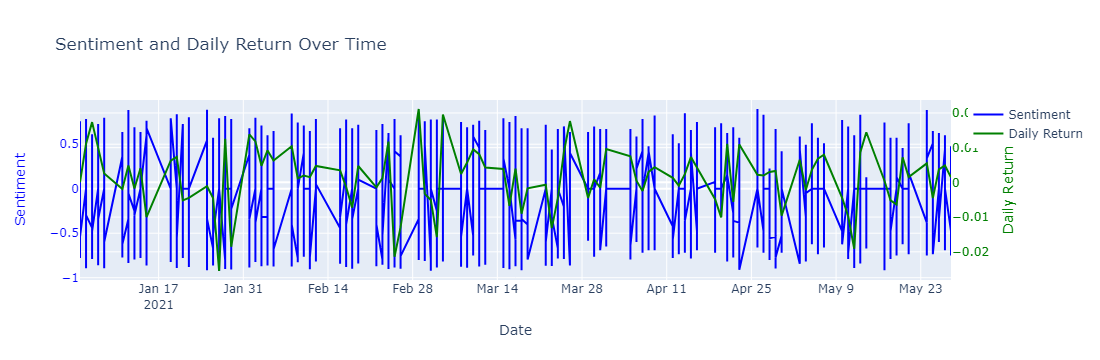

In [114]:
# Create figure with secondary y-axis
fig = go.Figure()

# Add sentiment trace
fig.add_trace(go.Scatter(x=merged_data['date'], y=merged_data['sentiment_compound'], mode='lines', name='Sentiment', line=dict(color='blue')))

# Add daily return trace on the secondary y-axis
fig.add_trace(go.Scatter(x=merged_data['date'], y=merged_data['daily_return'], mode='lines', name='Daily Return', line=dict(color='green'), yaxis='y2'))

# Update layout with titles and axis labels
fig.update_layout(title='Sentiment and Daily Return Over Time',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Sentiment', side='left', color='blue'),
                  yaxis2=dict(title='Daily Return', overlaying='y', side='right', color='green'))

# Show the interactive plot
fig.show()


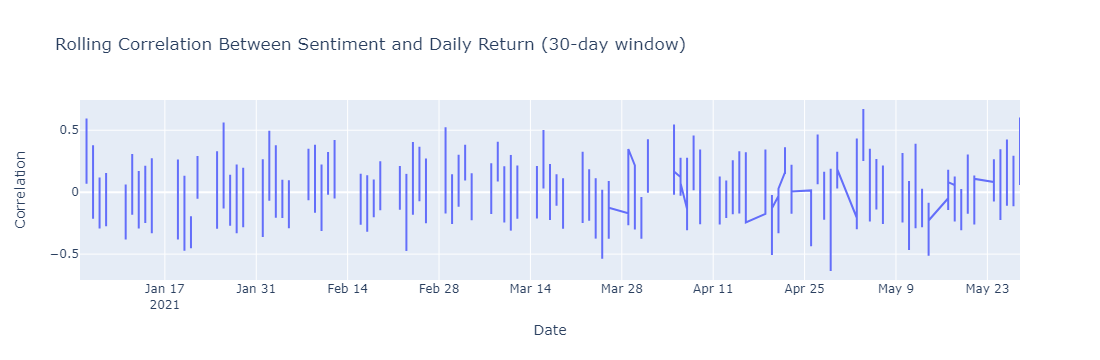

In [115]:
import plotly.graph_objects as go

# Define the rolling window size
rolling_window_size = 30  # You can adjust the window size as needed

# Calculate rolling correlations
rolling_correlations = merged_data['sentiment_compound'].rolling(window=rolling_window_size).corr(merged_data['daily_return'])

# Create a Plotly figure
fig = go.Figure()

# Add the rolling correlation trace
fig.add_trace(go.Scatter(x=merged_data['date'], y=rolling_correlations, mode='lines', name=f'Rolling Correlation ({rolling_window_size} days)'))

# Customize layout
fig.update_layout(title=f'Rolling Correlation Between Sentiment and Daily Return ({rolling_window_size}-day window)',
                  xaxis=dict(title='Date'),
                  yaxis=dict(title='Correlation'))

# Show the interactive plot
fig.show()


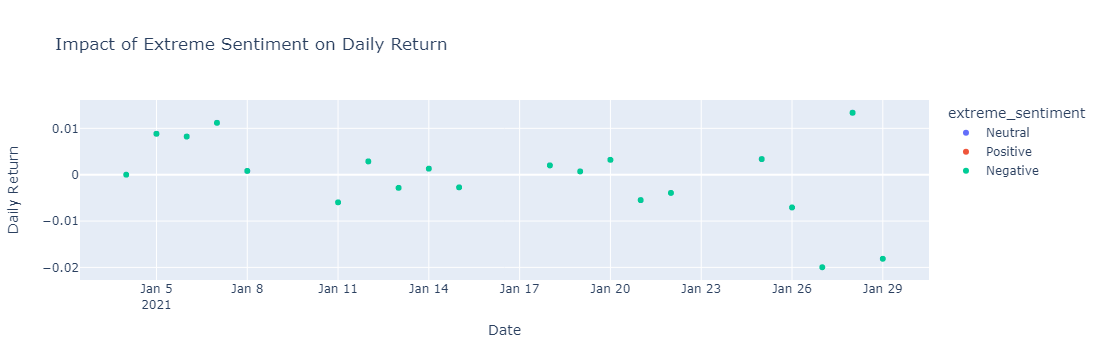

In [93]:
import plotly.express as px

# Define thresholds for extreme sentiment
positive_sentiment_threshold = 0.5
negative_sentiment_threshold = -0.5

# Create a new column indicating extreme sentiment
merged_data['extreme_sentiment'] = 'Neutral'
merged_data.loc[merged_data['sentiment_compound'] > positive_sentiment_threshold, 'extreme_sentiment'] = 'Positive'
merged_data.loc[merged_data['sentiment_compound'] < negative_sentiment_threshold, 'extreme_sentiment'] = 'Negative'

# Create a scatter plot with color-coded points based on extreme sentiment
fig = px.scatter(merged_data, x='date', y='daily_return', color='extreme_sentiment',
                 labels={'daily_return': 'Daily Return'},
                 title='Impact of Extreme Sentiment on Daily Return')

# Customize layout
fig.update_layout(xaxis_title='Date', yaxis_title='Daily Return')

# Show the interactive plot
fig.show()


                            OLS Regression Results                            
Dep. Variable:           daily_return   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     95.61
Date:                Tue, 12 Dec 2023   Prob (F-statistic):           1.85e-22
Time:                        21:07:29   Log-Likelihood:                 27508.
No. Observations:                8391   AIC:                        -5.501e+04
Df Residuals:                    8389   BIC:                        -5.500e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

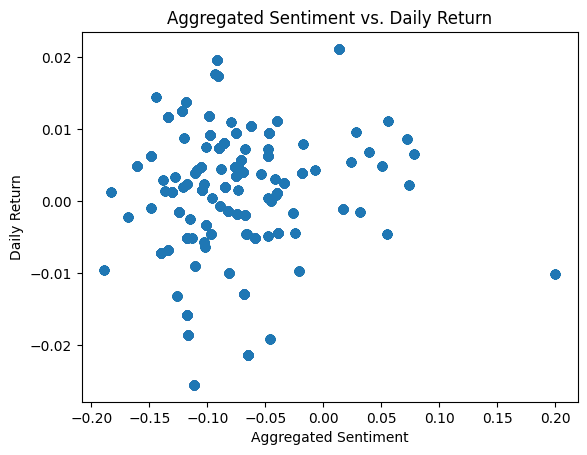

In [117]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'date' column is in datetime format
stock_data['date'] = pd.to_datetime(stock_data['date'])
news_data['date'] = pd.to_datetime(news_data['date'])

# Merge data
merged_data = pd.merge(stock_data, news_data, on='date', how='inner')

# Aggregate sentiment scores by date
aggregated_sentiment = merged_data.groupby('date')['sentiment_compound'].mean().reset_index()

# Merge aggregated sentiment with stock data
merged_data = pd.merge(merged_data, aggregated_sentiment, on='date', how='inner', suffixes=('', '_aggregated'))

# Regression Analysis
X = sm.add_constant(merged_data['sentiment_compound_aggregated'])
y = merged_data['daily_return']

model = sm.OLS(y, X).fit()
print(model.summary())

# Visualize the relationship
plt.scatter(merged_data['sentiment_compound_aggregated'], merged_data['daily_return'], alpha=0.5)
plt.title('Aggregated Sentiment vs. Daily Return')
plt.xlabel('Aggregated Sentiment')
plt.ylabel('Daily Return')
plt.show()


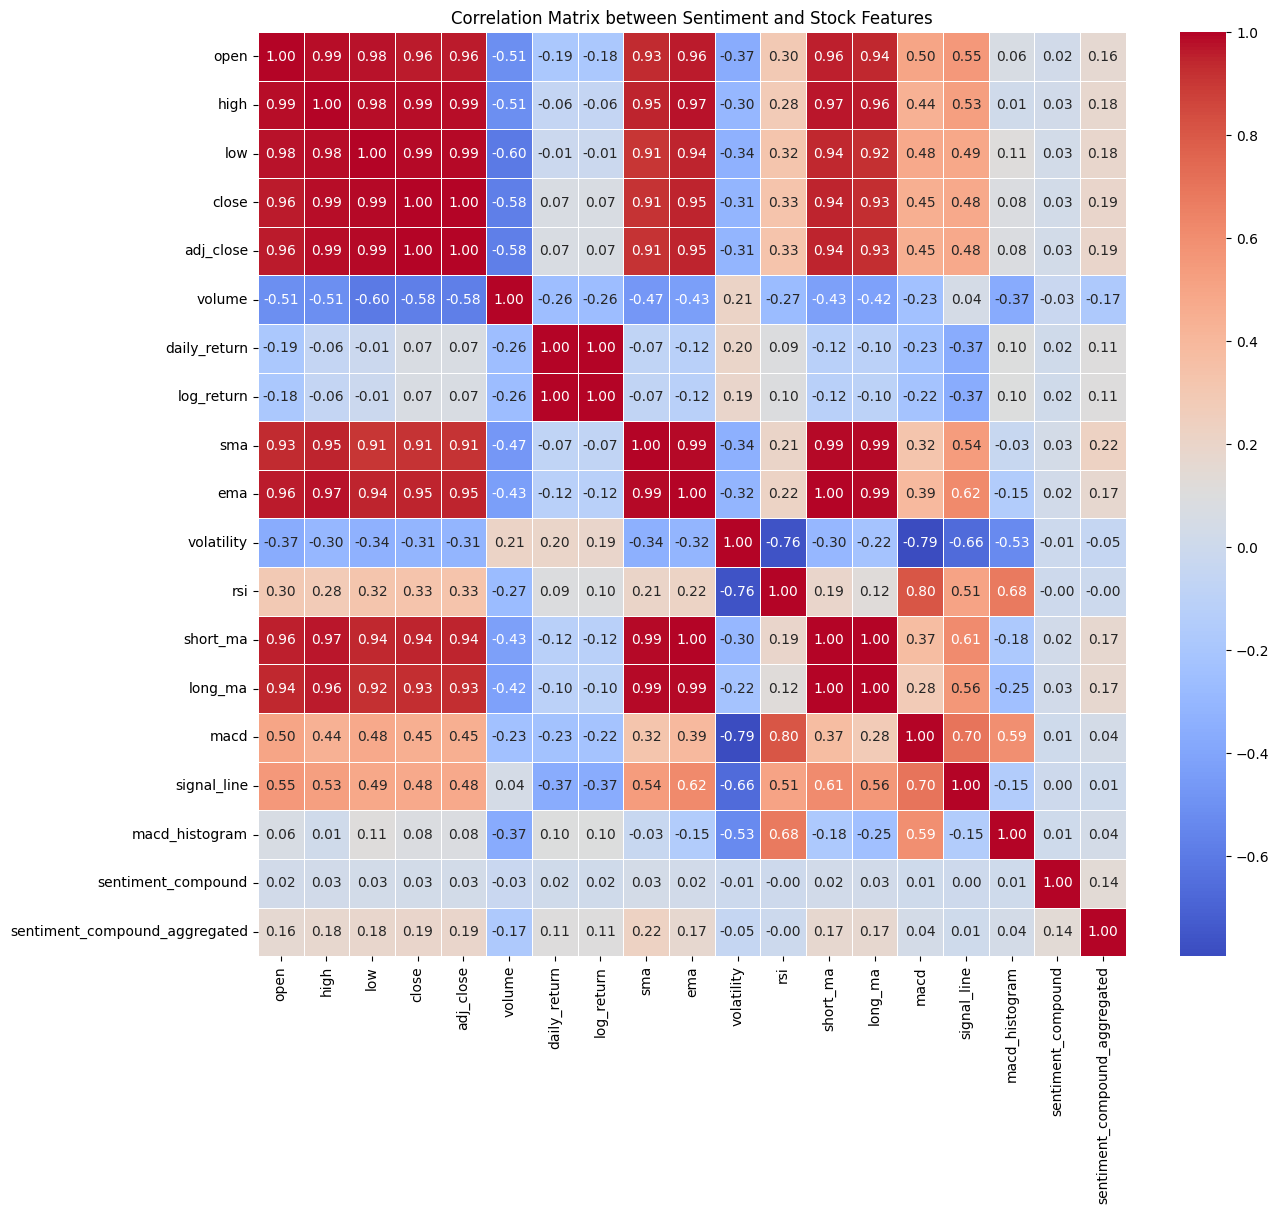

In [118]:
# Compute correlation matrix
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = merged_data[numeric_columns].corr()

# Perform further analysis or visualization as needed
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix between Sentiment and Stock Features')
plt.show()


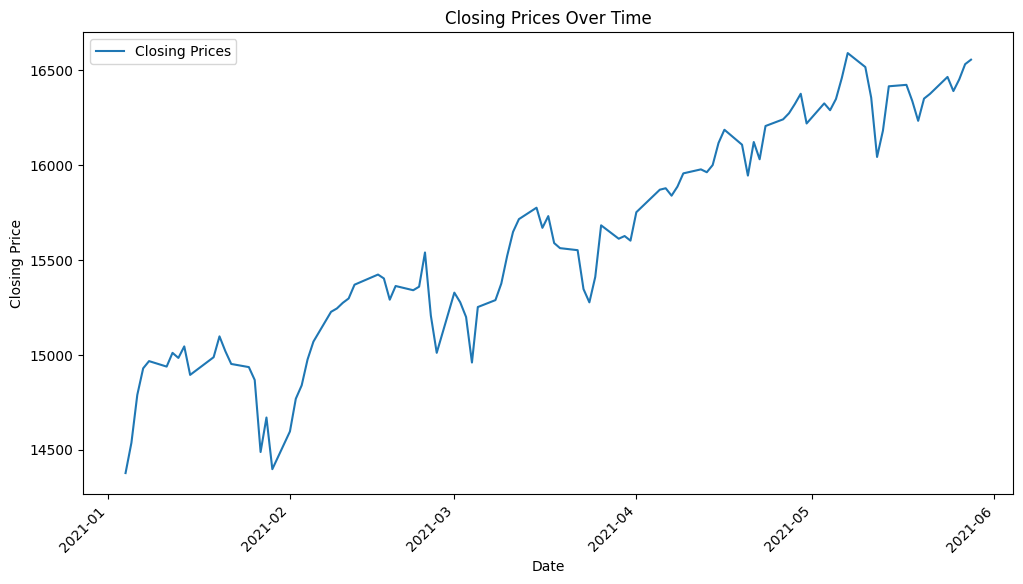

In [119]:
# Plotting Closing Prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data['date'], stock_data['close'], label='Closing Prices')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

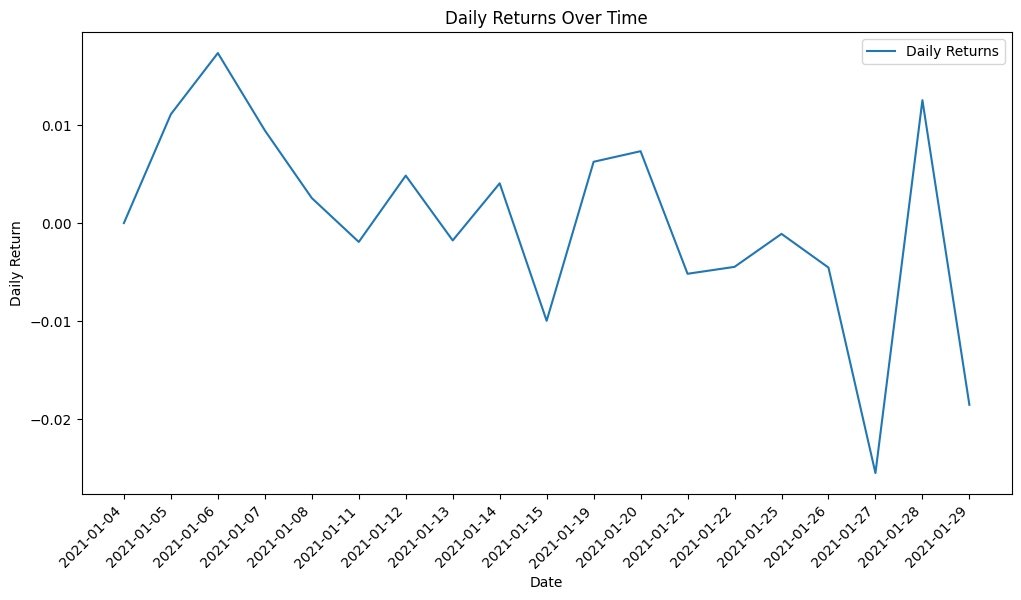

In [50]:
# Plotting Daily Returns
plt.figure(figsize=(12, 6))
plt.plot(stock_data['date'], stock_data['daily_return'], label='Daily Returns')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()

plt.xticks(rotation=45, ha='right')
plt.show()

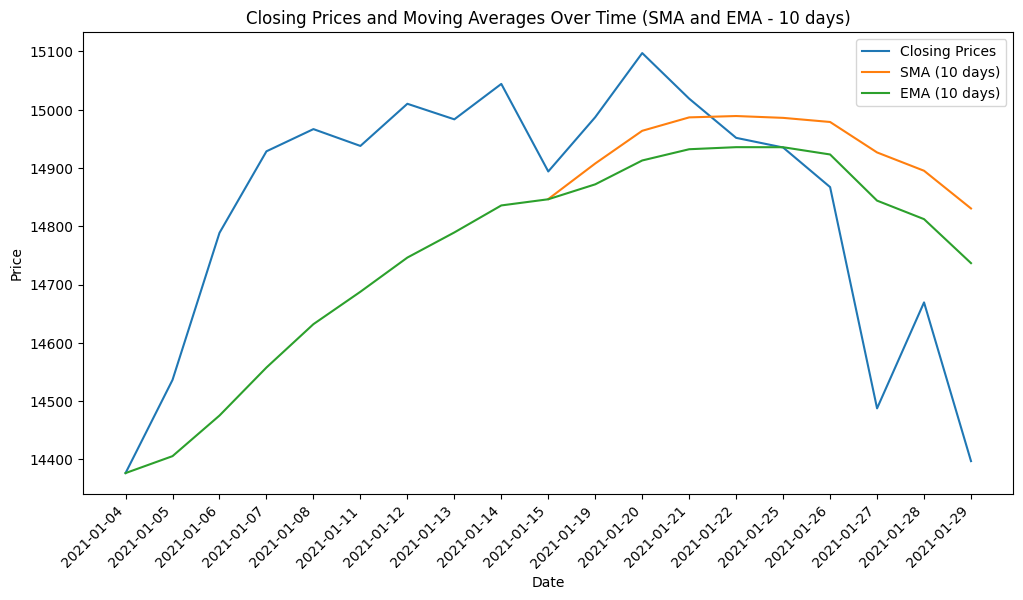

In [51]:
# Plotting Moving Averages (SMA and EMA)
plt.figure(figsize=(12, 6))
plt.plot(stock_data['date'], stock_data['close'], label='Closing Prices')
plt.plot(stock_data['date'], stock_data['sma'], label='SMA (10 days)')
plt.plot(stock_data['date'], stock_data['ema'], label='EMA (10 days)')
plt.title('Closing Prices and Moving Averages Over Time (SMA and EMA - 10 days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.xticks(rotation=45, ha='right')
plt.show()


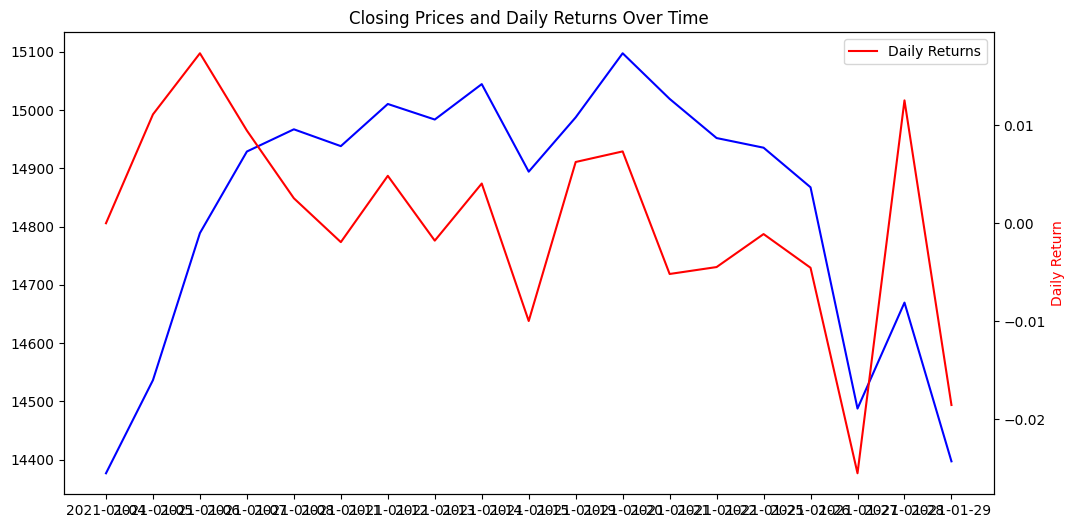

In [52]:
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.plot(stock_data['date'], stock_data['close'], label='Closing Prices', color='blue')

# Create a secondary y-axis for Daily Returns
ax2 = plt.gca().twinx()
ax2.plot(stock_data['date'], stock_data['daily_return'], label='Daily Returns', color='red')

# Set labels and title
plt.title('Closing Prices and Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price', color='blue')
ax2.set_ylabel('Daily Return', color='red')

# Display legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.xticks(stock_data['date'], rotation=45, ha='right')
plt.show()

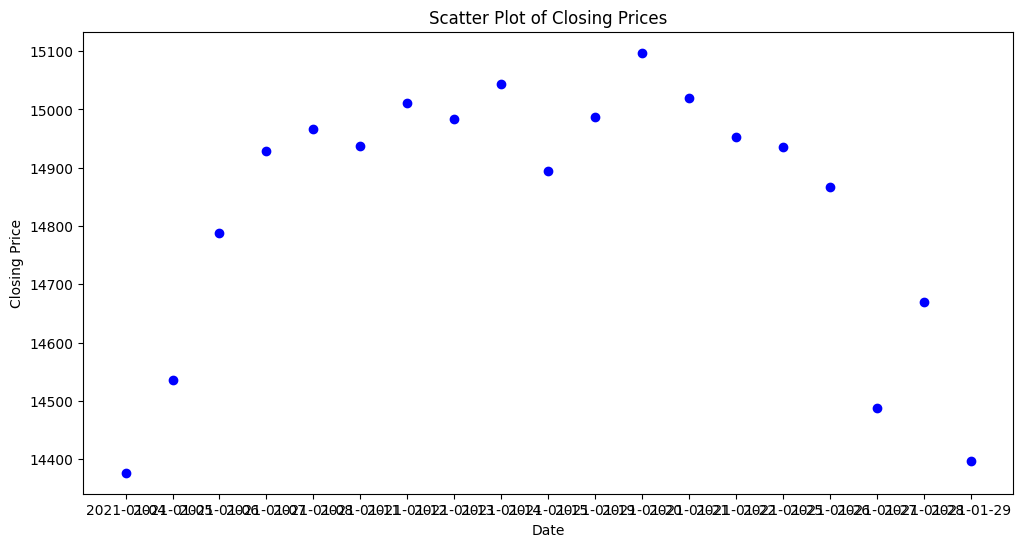

In [53]:
plt.figure(figsize=(12, 6))
plt.scatter(stock_data['date'], stock_data['close'], marker='o', color='blue')
plt.title('Scatter Plot of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


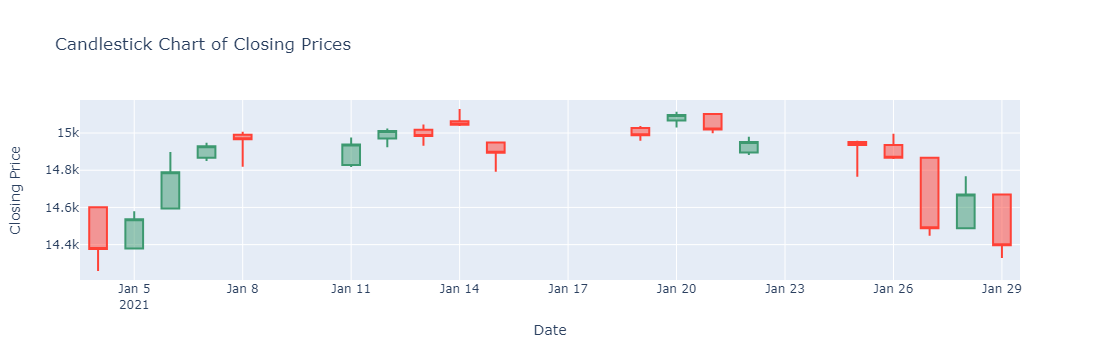

In [40]:
import plotly.graph_objects as go

# Create Candlestick Chart
fig = go.Figure(data=[go.Candlestick(x=stock_data['date'],
                open=stock_data['open'],
                high=stock_data['high'],
                low=stock_data['low'],
                close=stock_data['close'])])

# Set layout
fig.update_layout(title='Candlestick Chart of Closing Prices',
                  xaxis_title='Date',
                  yaxis_title='Closing Price',
                  xaxis_rangeslider_visible=False)

# Show the plot
fig.show()


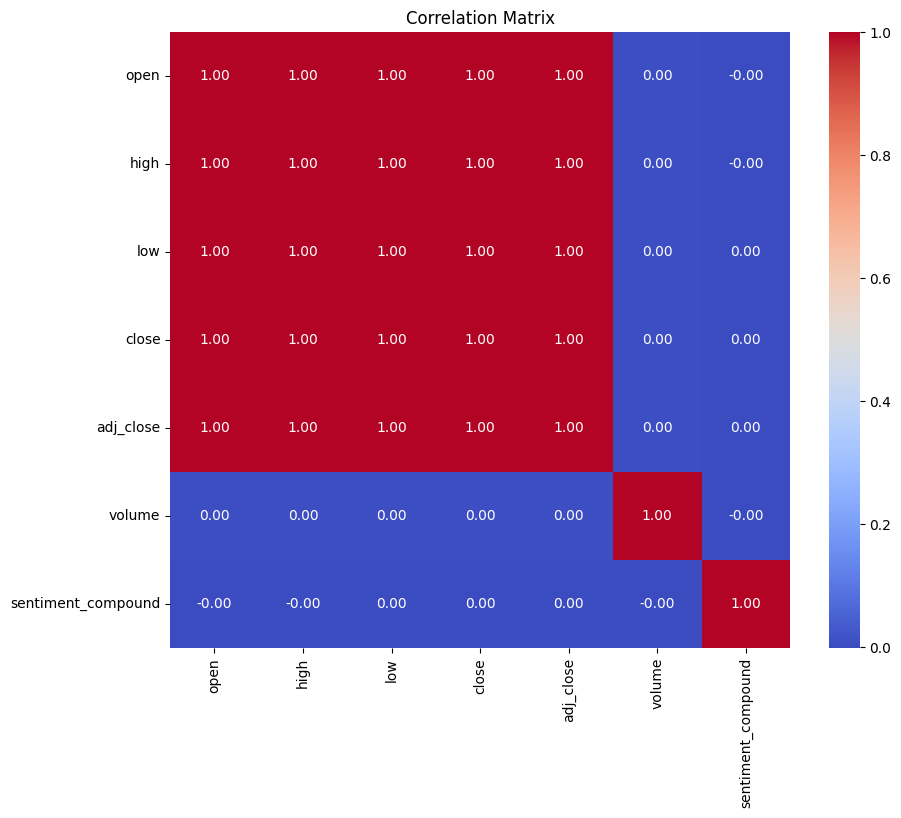

In [30]:
# Exclude non-numeric columns from the correlation matrix
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = merged_data[numeric_columns].corr()

# Perform further analysis or visualization as needed
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

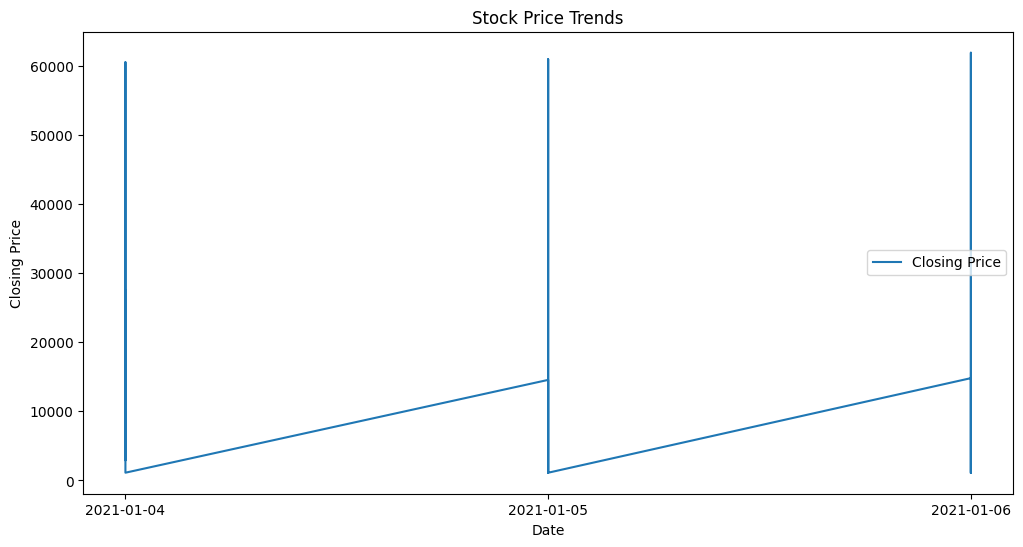

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(merged_data['date'], merged_data['close'], label='Closing Price')
plt.title('Stock Price Trends')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


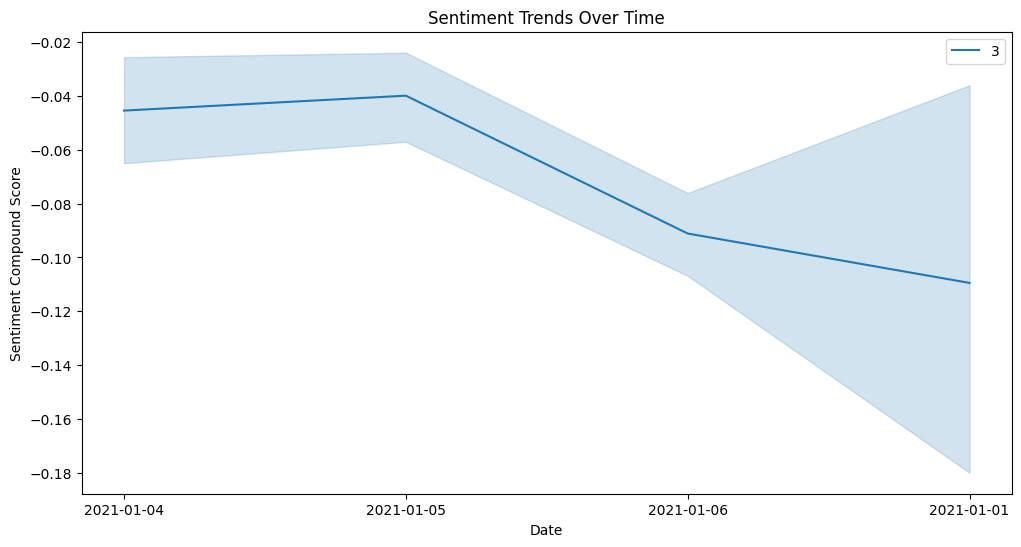

In [32]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sentiment_compound', hue='source', data=merged_data)
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment Compound Score')
plt.legend()
plt.show()


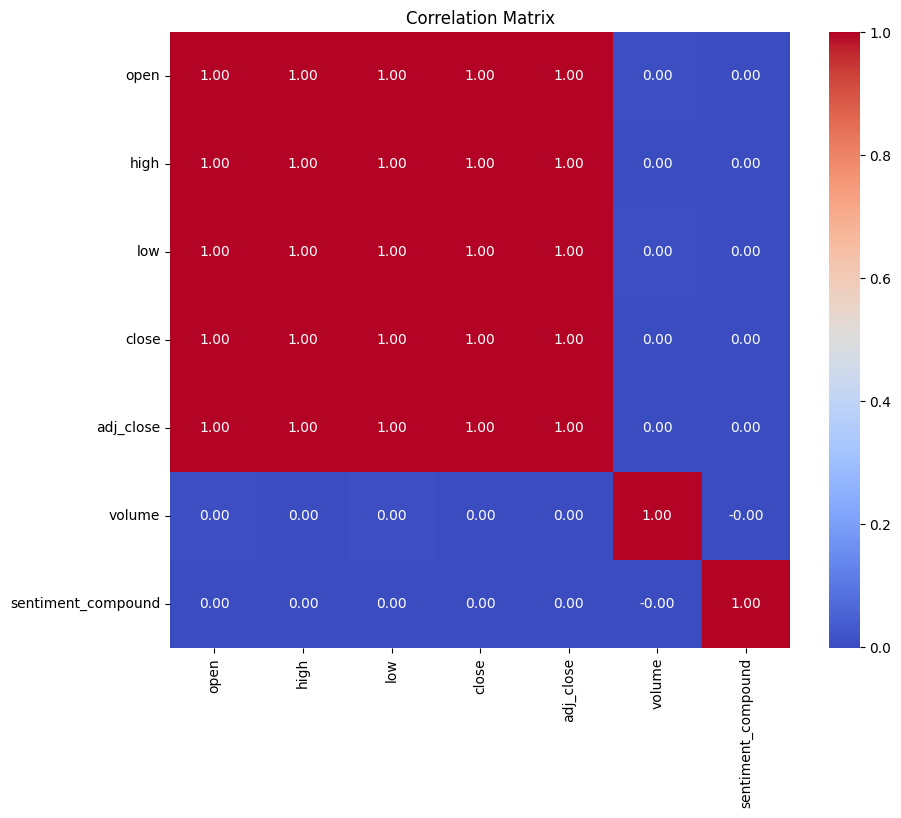

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


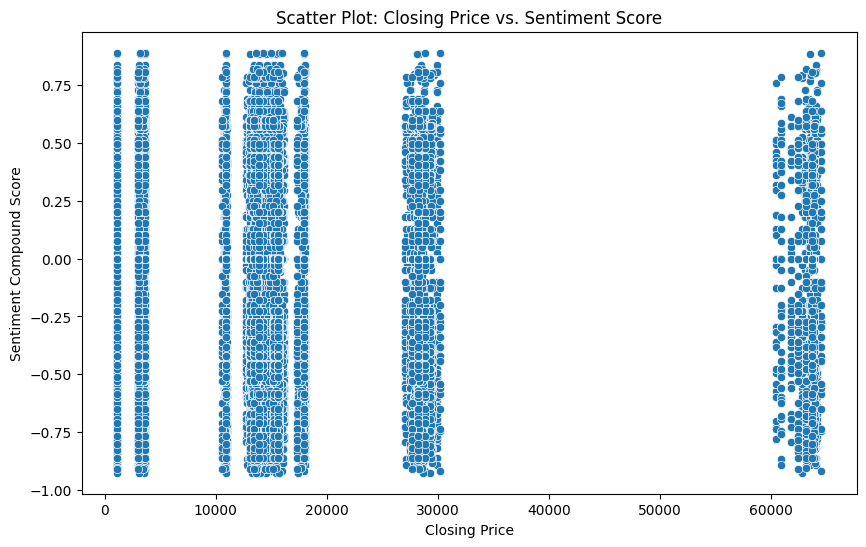

In [16]:
# Example: Scatter plot between closing price and sentiment score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='close', y='sentiment_compound', data=merged_data)
plt.title('Scatter Plot: Closing Price vs. Sentiment Score')
plt.xlabel('Closing Price')
plt.ylabel('Sentiment Compound Score')
plt.show()


In [17]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(' '.join(merged_data['keywords']))
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Keywords')
plt.show()

ValueError: We need at least 1 word to plot a word cloud, got 0.